# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# Set themes, styles and color palette for seaborn charts
sns.set_theme(style='darkgrid', context='poster')
sns.set_palette(palette='pastel', n_colors=10)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.titlesize"] = 14 
plt.rcParams["axes.labelsize"] = 12 
plt.rcParams["xtick.labelsize"] = 10 
plt.rcParams["ytick.labelsize"] = 10 

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [3]:
# Define a function to load data and aggregate them

def load_and_aggregate_data (root_folder, file_list):
    df = pd.DataFrame()

    for file in file_list:
        df_temp = pd.read_csv(os.path.join(root_folder, file))

        df = pd.concat([df, df_temp], ignore_index=True)

        print(f'Shape of data in {file} is {df_temp.shape}')

    print(f'Shape of aggregated data is {df.shape}')

    return df

In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
root_folder = 'RNN_Stocks_Data'

file_list = os.listdir(root_folder)

df = load_and_aggregate_data(root_folder, file_list)

Shape of data in AMZN_stocks_data.csv is (3019, 7)
Shape of data in GOOGL_stocks_data.csv is (3019, 7)
Shape of data in IBM_stocks_data.csv is (3020, 7)
Shape of data in MSFT_stocks_data.csv is (3019, 7)
Shape of aggregated data is (12077, 7)


In [5]:
# View specifics of the data
df.info()

# Quick observation
#-------------------
# 1. The date and name columns are loaded as object type. Hence change the data type.
#-------------------

df['Date'] = pd.to_datetime(df['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [7]:
# Handle Missing Values
# Re-used code from my LendingClubCaseStudy (https://github.com/uvarajthulasiram/LendingClubCaseStudy)
# Get the columns in the decending order of most number of null values 
print(df.isnull().sum().sort_values(ascending=False))

# Get those column which has null values accross the series
print(df.columns[df.isnull().all()])

# Let us find out how many columns has null values in all the rows.
print(f"Number of columns with null values in all the rows: {df.columns[df.isnull().all()].size}")

df[df['Open'].isnull() | df['Close'].isnull()]

# Quick observation
#-------------------
# 1. There are only two null values spread across in columns 'open' and 'close'
# 2. There are no columns with null values across all rows.
# 3. Ticker 'IBM' has null value in columns 'open' and 'close' on 31-July-2017. We can drop the row.
#-------------------

Open      1
Low       1
Date      0
High      0
Close     0
Volume    0
Name      0
dtype: int64
Index([], dtype='object')
Number of columns with null values in all the rows: 0


,Date,Open,High,Low,Close,Volume,Name
8951,2017-07-31,NaN,144.93,NaN,144.67,4355718,IBM


In [8]:
df = df[~(df['Open'].isnull() | df['Close'].isnull())]

df.shape

(12076, 7)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

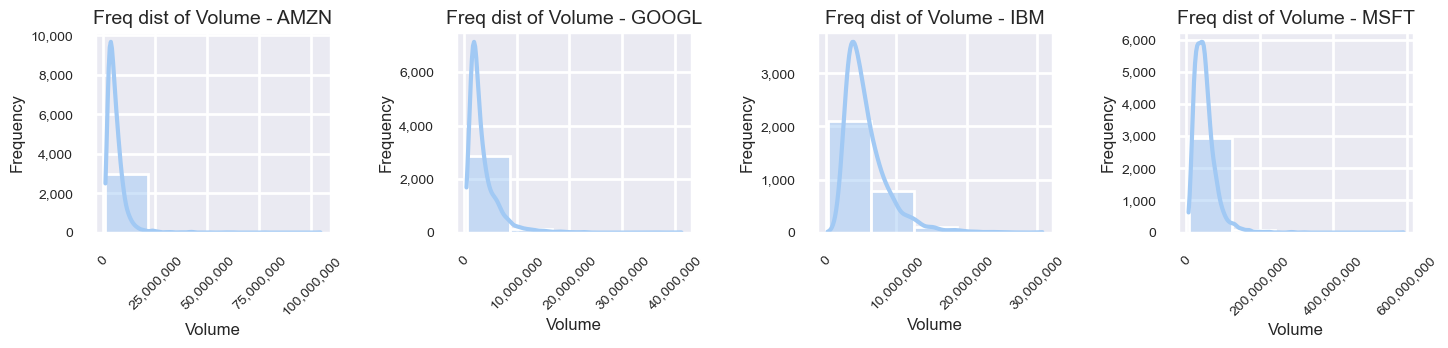

In [9]:
# Frequency distribution of volumes
import matplotlib.ticker as ticker

stocks = df['Name'].unique()
num_stocks = len(stocks)

num_cols = 4
num_rows = (num_stocks + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

axes = axes.flatten()

for i, stock in enumerate(stocks):
    sns.histplot(data=df[df['Name'] == stock]['Volume'], bins=5, kde=True, ax=axes[i])
    axes[i].set_title(f'Freq dist of Volume - {stock}')
    axes[i].set_xlabel('Volume') 
    axes[i].set_ylabel("Frequency")
    axes[i].tick_params(axis='x', rotation=45)

    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Quick observation
#-------------------
# 1. Looks like there are a lot of outliers! @Praveen, we'll discuss this.
#-------------------

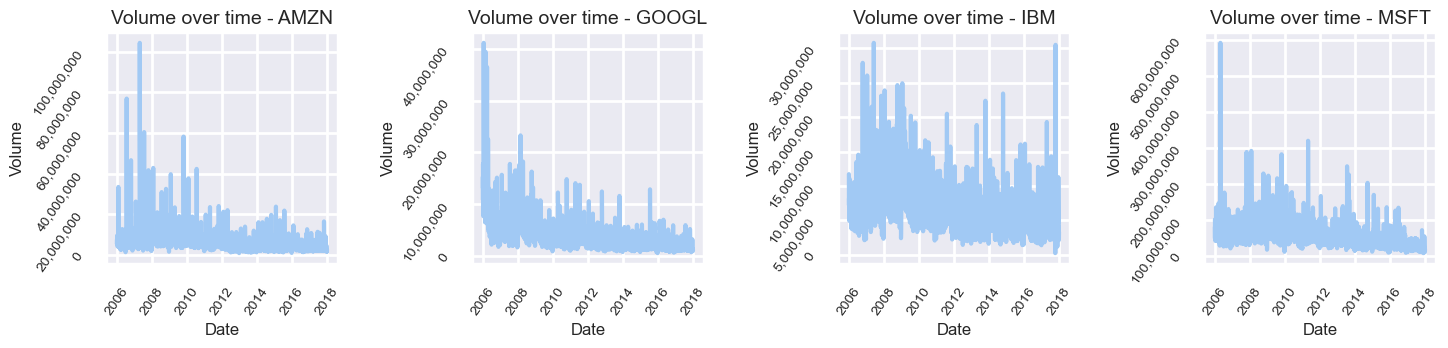

In [10]:
# Stock volume variation over time
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

axes = axes.flatten()

for i, stock in enumerate(stocks):
    sns.lineplot(data=df[df['Name'] == stock], x='Date', y='Volume', ax=axes[i])
    axes[i].set_title(f'Volume over time - {stock}')
    axes[i].set_xlabel('Date') 
    axes[i].set_ylabel("Volume")
    axes[i].tick_params(axis='x', rotation=55)
    axes[i].tick_params(axis='y', rotation=55)

    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Quick observation
#-------------------
# 1. Volume has decreased over time for all the stocks
#-------------------

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

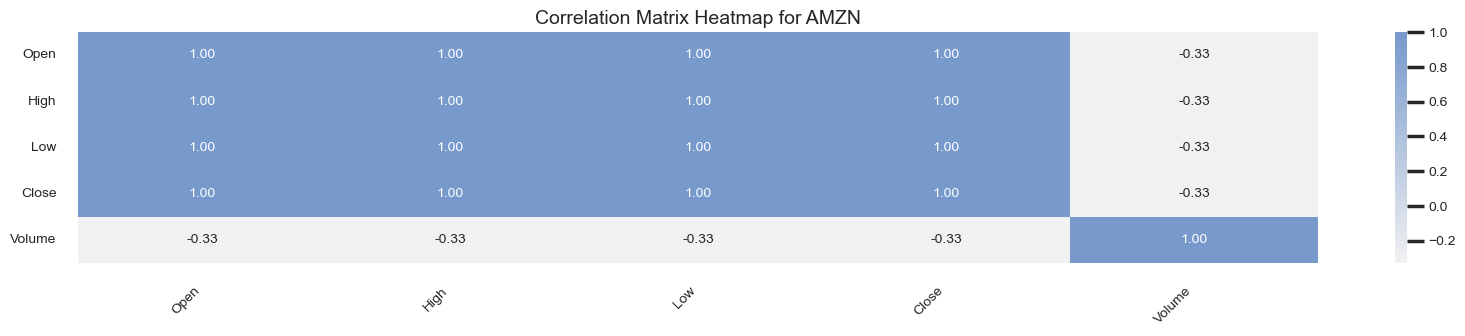

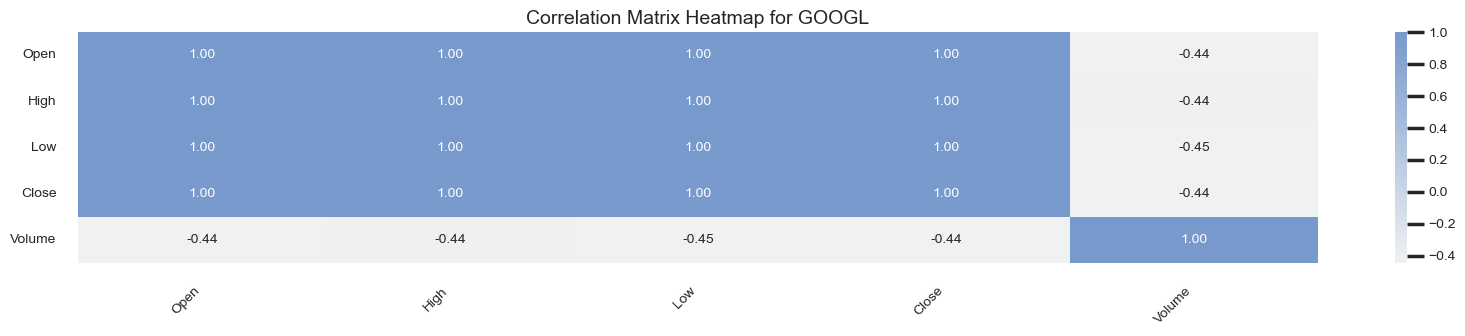

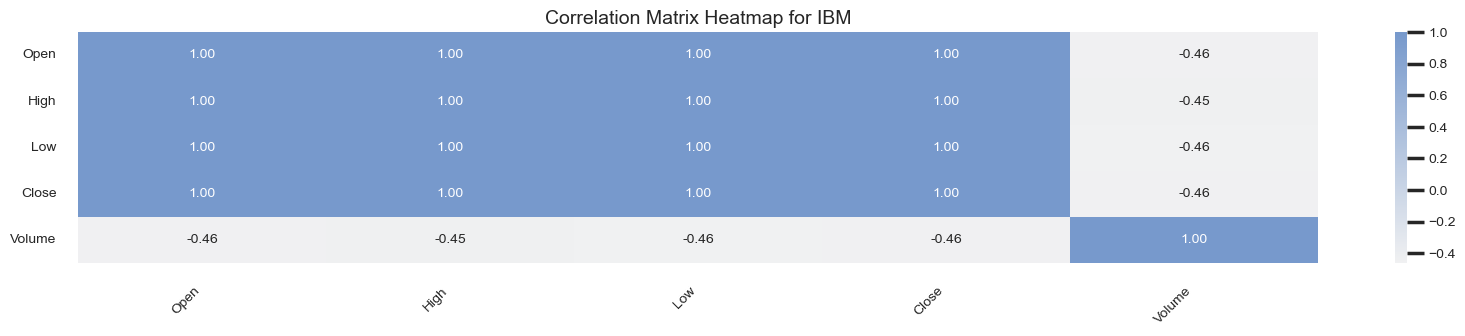

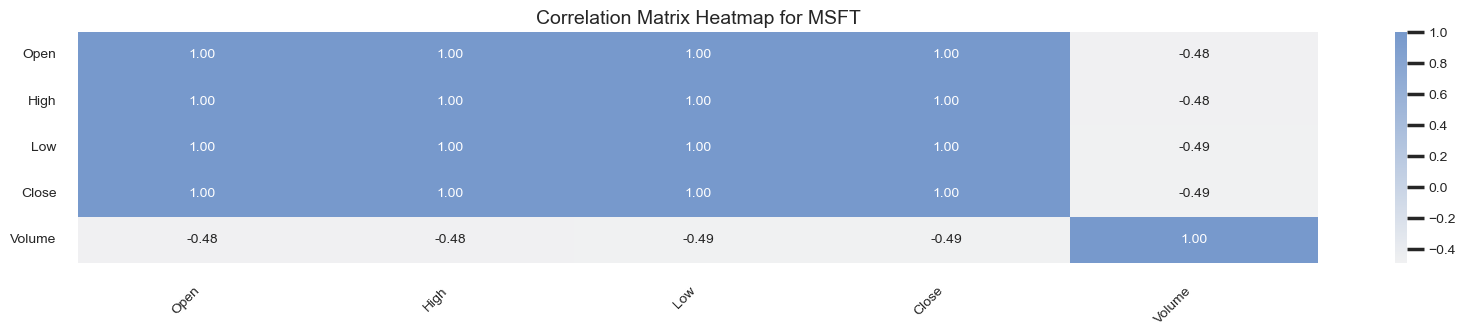

In [11]:
# Analyse correlations
for i, stock in enumerate(stocks):
    numeric_features = df[df['Name'] == stock].select_dtypes('number')
    plt.figure(figsize=(20, 3))
    sns.heatmap(data=numeric_features.corr(), annot=True, annot_kws={'fontsize': 10}, cmap=sns.light_palette("#79c", as_cmap=True), fmt='.2f')

    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10, rotation=0)
    plt.title(f"Correlation Matrix Heatmap for {stock}")
    plt.show()


# Quick observation
#-------------------
# 1. As prices go up volume goes down
#       AMZN - Volume goes down by 33% when the price goes up and vice versa
#       GOOGL - 44%
#       IBM - 45%
#       MSFT - 48%
#-------------------


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [12]:
# Define a function that divides the data into windows and generates target variable values for each window
def get_windowed_data(input_df, window_size=3, step_size=1, target_stocks=None):
    input_df = input_df[input_df['Name'].isin(target_stocks)]

    unique_stocks = input_df['Name'].unique()
    sorted_df = input_df.sort_values(['Name', 'Date']).reset_index(drop=True)
    
    X_windows = []
    y_values = []

    for stock in unique_stocks:
        sorted_df_filtered_by_name = sorted_df[sorted_df['Name'] == stock]

        for start_idx in range(0, len(sorted_df_filtered_by_name) - window_size, step_size):
            end_idx = start_idx + window_size

            if end_idx >= len(sorted_df_filtered_by_name):
                break

            X_windows.append(sorted_df_filtered_by_name.iloc[start_idx:end_idx])
            y_values.append(sorted_df_filtered_by_name.iloc[end_idx]['Close'])

    return X_windows, y_values

In [ ]:
target_stocks = ['AMZN', 'GOOGL']

X_windows, y_values = get_windowed_data(df, target_stocks=target_stocks)

print(X_windows[0], y_values[0])
print(X_windows[1], y_values[1])
print(X_windows[2], y_values[2])

print(X_windows[-3], y_values[-3])
print(X_windows[-2], y_values[-2])
print(X_windows[-1], y_values[-1])

# Quick observation
#-------------------
# X_window[0] is the first three observations from the data
# y_values[0] is the 4th observations value in 'Close' column.
# Similarly we'll have 12076 - 3 = 12073 windows of data 
#-------------------

        Date   Open   High    Low  Close   Volume  Name
0 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN 47.87
        Date   Open   High    Low  Close   Volume  Name
1 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN 47.08
        Date   Open   High    Low  Close   Volume  Name
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4 2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN 45.65
           Date     Open     High      Low    Close   Volume   Name
6032 2017-12-21  1075.39  1077.52  1069.00  1070.85  1282025  GOOGL
6033 2017-12-22  1070.00  1071.72  1067.64  1068.86   889446  GOOGL
6034 2017-12-26  1068.64  1068.86  1058.64  1065.85   918767  GOOGL 1060.2
           Date     Open     Hi

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [28]:
# Define a function that scales the windowed data
def scale_windowed_data(param_windows, param_values):
    X_scaled = []
    y_scaled= []

    # I'm using MinMaxScaler from sklearn for scaling 
    # When no min and max values are passed in, the defaule min and max are 0 and 1.
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    # Train the scaler to learn the windowed data
    for window in param_windows:
        X_scaler.partial_fit(window.select_dtypes(include='number'))

    for value in param_values:
        y_scaler.partial_fit(np.array([[value]]))
        
    for window in param_windows:
        X_scaled.append(X_scaler.transform(window.select_dtypes(include='number')))

    # y_scaler needs 2D array. Hence converting param_values to 2D array
    y_2d_values = np.array(param_values).reshape(-1, 1)
    y_scaled = y_scaler.transform(y_2d_values)

    return X_scaled, y_scaled


In [29]:
# The function takes in the windowed data sets and returns the scaled windows
X_scaled, y_scaled = scale_windowed_data(X_windows, y_values)

print(X_windows[0], y_values[0])
print(X_scaled[0], y_scaled[0])

# Quick observation
#-------------------
# The numeric values in the windows and values are scaled now and are between 0 and 1
#-------------------

        Date   Open   High    Low  Close   Volume  Name
0 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN 47.87
[[0.01813724 0.01815333 0.0175821  0.01838839 0.06797027]
 [0.01814573 0.01805224 0.01795965 0.01810628 0.06661093]
 [0.01787426 0.01844816 0.01832005 0.01844823 0.04713087]] [0.0186363]


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [ ]:
# Checking for patterns in different sequence lengths



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride



In [ ]:
# Check the number of data points generated


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks



## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration based on evaluation metrics



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model



Plotting the actual vs predicted values

In [ ]:
# Predict on the test data and plot



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set



### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.